In [2]:
from google.colab import drive    #Mounting drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/IR PROJECT'   # locating data directory(path)

In [5]:
import time
import pandas as pd
import numpy as np
import nltk
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
#!pip install pylanguagetool

#!pip install catboost
# from catboost import CatBoostClassifier

In [6]:
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

In [7]:
data = pd.read_csv(f"{data_dir}/fake reviews dataset_IR.csv")   
data # reading from csv file

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
4051,Home_and_Kitchen_5,5,OR,I bought this vacuum cleaner 3 months ago and ...
4052,Home_and_Kitchen_5,5,CG,I have a whole set of containers and they look...
4053,Home_and_Kitchen_5,5,OR,I purchased this after a friend recommended it...
4054,Home_and_Kitchen_5,5,CG,"Well, I've been curious about this set and am ..."


In [8]:
data['label'].value_counts()

CG    2028
OR    2028
Name: label, dtype: int64

In [9]:
data['text_'] = data['text_'].str.replace('\n', ' ')#strip out the \n newline character present and convert it to a space using str.replace().
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [10]:
data['label'].value_counts()

CG    2028
OR    2028
Name: label, dtype: int64

In [11]:
data['target'] = np.where(data['label']=='CG', 0, 1)
data.head()

,category,rating,label,text_,target
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0


In [12]:
data['target'].value_counts()

0    2028
1    2028
Name: target, dtype: int64

In [13]:
data.columns

Index(['category', 'rating', 'label', 'text_', 'target'], dtype='object')

In [14]:
import re

In [15]:
def punctuation_to_features(data, column):  
    
    data[column] = data[column].replace('!', ' exclamation ')
    data[column] = data[column].replace('?', ' question ')
    data[column] = data[column].replace('\'', ' quotation ')
    data[column] = data[column].replace('\"', ' quotation ')
    
    return data[column]
data['text_'] = punctuation_to_features(data, 'text_')

In [16]:
nltk.download('punkt');

def tokenize(column):
   
    
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
data['tokenized'] = data.apply(lambda x: tokenize(x['text_']), axis=1)
data.head()

,category,rating,label,text_,target,tokenized
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ..."
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had..."


In [19]:
def remove_stopwords(tokenized_column):
    
    stops = set(stopwords.words("english"))
    return [word for word in tokenized_column if not word in stops]


In [20]:
nltk.download('stopwords')
data['stopwords_removed'] = data.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,category,rating,label,text_,target,tokenized,stopwords_removed
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee..."
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,..."


In [21]:
def apply_stemming(tokenized_column):
    
    stemmer = PorterStemmer() 
    return [stemmer.stem(word).lower() for word in tokenized_column]
data['porter_stemmed'] = data.apply(lambda x: apply_stemming(x['stopwords_removed']), axis=1)
data.head()

,category,rating,label,text_,target,tokenized,stopwords_removed,porter_stemmed
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,..."
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]"
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,...","[veri, nice, set, good, qualiti, we, set, two,..."


In [22]:
data['modified'] = [' '.join(wrd for wrd in x) for x in data['porter_stemmed']]
data.head()

,category,rating,label,text_,target,tokenized,stopwords_removed,porter_stemmed,modified
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v...",love well made sturdi comfort i love veri pretti
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ...",love great upgrad origin i mine coupl year
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,...",thi pillow save back i love look feel pillow
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]",miss inform use great product price i
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,...","[veri, nice, set, good, qualiti, we, set, two,...",veri nice set good qualiti we set two month


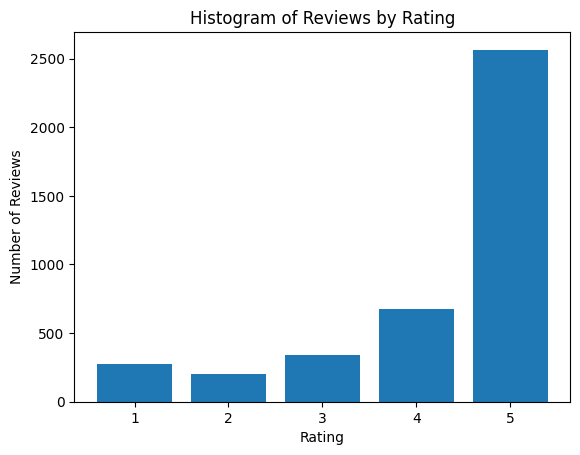

In [23]:

# group by rating and count number of reviews
ratings = data.groupby('rating')['modified'].count()

# create histogram
plt.bar(ratings.index, ratings.values)

# set labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Reviews by Rating')

# display plot
plt.show()

In [24]:
data['rating'].astype(int)

0       5
1       5
2       5
3       1
4       5
       ..
4051    5
4052    5
4053    5
4054    5
4055    5
Name: rating, Length: 4056, dtype: int64

In [25]:
data

,category,rating,label,text_,target,tokenized,stopwords_removed,porter_stemmed,modified
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v...",love well made sturdi comfort i love veri pretti
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ...",love great upgrad origin i mine coupl year
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,...",thi pillow save back i love look feel pillow
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]",miss inform use great product price i
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,...","[veri, nice, set, good, qualiti, we, set, two,...",veri nice set good qualiti we set two month
...,...,...,...,...,...,...,...,...,...
4051,Home_and_Kitchen_5,5,OR,I bought this vacuum cleaner 3 months ago and ...,1,"[I, bought, this, vacuum, cleaner, months, ago...","[I, bought, vacuum, cleaner, months, ago, abso...","[i, bought, vacuum, cleaner, month, ago, absol...",i bought vacuum cleaner month ago absolut love...
4052,Home_and_Kitchen_5,5,CG,I have a whole set of containers and they look...,0,"[I, have, a, whole, set, of, containers, and, ...","[I, whole, set, containers, look, like, ones, ...","[i, whole, set, contain, look, like, one, i, u...",i whole set contain look like one i use i repl...
4053,Home_and_Kitchen_5,5,OR,I purchased this after a friend recommended it...,1,"[I, purchased, this, after, a, friend, recomme...","[I, purchased, friend, recommended, I, power, ...","[i, purchas, friend, recommend, i, power, bake...",i purchas friend recommend i power baker i mer...
4054,Home_and_Kitchen_5,5,CG,"Well, I've been curious about this set and am ...",0,"[Well, I, been, curious, about, this, set, and...","[Well, I, curious, set, pleased, The, dimensio...","[well, i, curiou, set, pleas, the, dimens, rig...",well i curiou set pleas the dimens right the b...


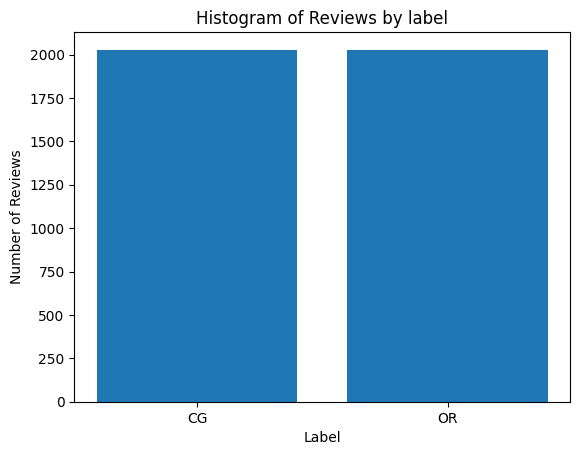

In [26]:

# group by rating and count number of reviews
labels = data.groupby('label')['modified'].count()

# create histogram
plt.bar(labels.index, labels.values)

# set labels and title
plt.xlabel('Label')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Reviews by label')

# display plot
plt.show()

In [27]:

from textblob import TextBlob


# Define a function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the 'review' column
data['sentiment'] = data['text_'].apply(get_sentiment)

# Define a function to label reviews as positive, negative, or neutral
def get_sentiment_label(sentiment):
    if sentiment > 0.5:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment label to the DataFrame
data['sentiment_label'] = data['sentiment'].apply(get_sentiment_label)

# Count the number of positive, negative, and neutral reviews
sentiment_counts = data['sentiment_label'].value_counts()

# Print the sentiment counts
print(sentiment_counts)




neutral     3078
positive     594
negative     384
Name: sentiment_label, dtype: int64


In [28]:
data.head(20)

,category,rating,label,text_,target,tokenized,stopwords_removed,porter_stemmed,modified,sentiment,sentiment_label
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v...",love well made sturdi comfort i love veri pretti,0.473750,neutral
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ...",love great upgrad origin i mine coupl year,0.558333,positive
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,...",thi pillow save back i love look feel pillow,0.250000,neutral
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]",miss inform use great product price i,0.400000,neutral
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,...","[veri, nice, set, good, qualiti, we, set, two,...",veri nice set good qualiti we set two month,0.740000,positive
5,Home_and_Kitchen_5,3,CG,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.,0,"[I, WANTED, DIFFERENT, FLAVORS, BUT, THEY, ARE...","[I, WANTED, DIFFERENT, FLAVORS, BUT, THEY, ARE...","[i, want, differ, flavor, but, they, are, not]",i want differ flavor but they are not,0.000000,neutral
6,Home_and_Kitchen_5,5,CG,They are the perfect touch for me and the only...,0,"[They, are, the, perfect, touch, for, me, and,...","[They, perfect, touch, thing, I, wish, little,...","[they, perfect, touch, thing, i, wish, littl, ...",they perfect touch thing i wish littl space,0.328125,neutral
7,Home_and_Kitchen_5,3,CG,These done fit well and look great. I love th...,0,"[These, done, fit, well, and, look, great, I, ...","[These, done, fit, well, look, great, I, love,...","[these, done, fit, well, look, great, i, love,...",these done fit well look great i love smooth e...,0.425000,neutral
8,Home_and_Kitchen_5,5,CG,"Great big numbers & easy to read, the only thi...",0,"[Great, big, numbers, easy, to, read, the, onl...","[Great, big, numbers, easy, read, thing, I, li...","[great, big, number, easi, read, thing, i, lik...",great big number easi read thing i like size,0.308333,neutral
9,Home_and_Kitchen_5,5,CG,My son loves this comforter and it is very wel...,0,"[My, son, loves, this, comforter, and, it, is,...","[My, son, loves, comforter, well, made, We, al...","[my, son, love, comfort, well, made, we, also,...",my son love comfort well made we also babi,0.200000,neutral


In [29]:

from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform text data to BoW representation
bow_features = vectorizer.fit_transform(data['modified'])

# Convert sparse matrix to dataframe
bow_df = pd.DataFrame(bow_features.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate bow features with original dataframe
df = pd.concat([data, bow_df], axis=1)

df.head()


,category,rating,label,text_,target,tokenized,stopwords_removed,porter_stemmed,modified,sentiment,...,zip,ziploc,zipper,ziti,zojirushi,zoo,zoodl,zucchini,zuchinni,zyliss
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v...",love well made sturdi comfort i love veri pretti,0.473750,...,0,0,0,0,0,0,0,0,0,0
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ...",love great upgrad origin i mine coupl year,0.558333,...,0,0,0,0,0,0,0,0,0,0
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,...",thi pillow save back i love look feel pillow,0.250000,...,0,0,0,0,0,0,0,0,0,0
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]",miss inform use great product price i,0.400000,...,0,0,0,0,0,0,0,0,0,0
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,...","[veri, nice, set, good, qualiti, we, set, two,...",veri nice set good qualiti we set two month,0.740000,...,0,0,0,0,0,0,0,0,0,0


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer



# Create CountVectorizer object and fit to data
vectorizer = CountVectorizer()
vectorizer.fit(data["modified"])

# Get list of unique words in vocabulary
vocabulary = vectorizer.get_feature_names_out()

# Transform text data into bag of words matrix
bag_of_words = vectorizer.transform(data["modified"])

# Create dataframe from bag of words matrix
df_bag_of_words = pd.DataFrame(bag_of_words.toarray(), columns=vocabulary)

# Print bag of words matrix
df_bag_of_words.head()


,aa,aaa,ab,abil,abl,about,abridg,abruptli,absolut,absorb,...,zip,ziploc,zipper,ziti,zojirushi,zoo,zoodl,zucchini,zuchinni,zyliss
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
x = data['modified']
y = data['target']

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, shuffle=True)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2839,)
(1217,)
(2839,)
(1217,)


In [33]:
# Split the dataset into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Convert text data to bag-of-words matrix
vectorizer = CountVectorizer()
train_bow_matrix = vectorizer.fit_transform(train_data['modified'])
test_bow_matrix = vectorizer.transform(test_data['modified'])

# Train logistic regression model
lr = LogisticRegression()
lr_model = lr.fit(train_bow_matrix, train_data['target'])

# Evaluate model on test data
accuracy = lr_model.score(test_bow_matrix, test_data['target'])
print("Accuracy:", accuracy)

Accuracy: 0.9285714285714286


In [34]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model = svm.fit(train_bow_matrix, train_data['target'])
# Evaluate model on test data
accuracy1 = svm.score(test_bow_matrix, test_data['target'])
print("Accuracy:", accuracy1)


Accuracy: 0.8817733990147784


In [35]:
df.head()

,category,rating,label,text_,target,tokenized,stopwords_removed,porter_stemmed,modified,sentiment,...,zip,ziploc,zipper,ziti,zojirushi,zoo,zoodl,zucchini,zuchinni,zyliss
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v...",love well made sturdi comfort i love veri pretti,0.473750,...,0,0,0,0,0,0,0,0,0,0
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ...",love great upgrad origin i mine coupl year,0.558333,...,0,0,0,0,0,0,0,0,0,0
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,...",thi pillow save back i love look feel pillow,0.250000,...,0,0,0,0,0,0,0,0,0,0
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]",miss inform use great product price i,0.400000,...,0,0,0,0,0,0,0,0,0,0
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,...","[veri, nice, set, good, qualiti, we, set, two,...",veri nice set good qualiti we set two month,0.740000,...,0,0,0,0,0,0,0,0,0,0


In [36]:

from nltk.sentiment import SentimentIntensityAnalyzer

# Download the stop words and initialize the sentiment analyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

# Extract the sentiment
df['sentimentnew'] = df['modified'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Evaluate coherence
df['coherence'] = df.apply(lambda row: row['sentimentnew'] > 0 and row['rating'] >= 3 or row['sentimentnew'] < 0 and row['rating'] < 3, axis=1)

# Use a logistic regression model to classify the reviews as genuine or fake
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[['sentimentnew']]
Y = df['coherence']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

lr = LogisticRegression()
lr_model = lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

print(classification_report(Y_test, Y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


              precision    recall  f1-score   support

       False       0.82      0.61      0.70       226
        True       0.92      0.97      0.94       991

    accuracy                           0.90      1217
   macro avg       0.87      0.79      0.82      1217
weighted avg       0.90      0.90      0.90      1217



In [37]:
df.head()

,category,rating,label,text_,target,tokenized,stopwords_removed,porter_stemmed,modified,sentiment,...,zipper,ziti,zojirushi,zoo,zoodl,zucchini,zuchinni,zyliss,sentimentnew,coherence
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",0,"[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v...",love well made sturdi comfort i love veri pretti,0.473750,...,0,0,0,0,0,0,0,0,0.9186,True
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",0,"[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ...",love great upgrad origin i mine coupl year,0.558333,...,0,0,0,0,0,0,0,0,0.8519,True
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,0,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,...",thi pillow save back i love look feel pillow,0.250000,...,0,0,0,0,0,0,0,0,0.8126,True
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",0,"[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]",miss inform use great product price i,0.400000,...,0,0,0,0,0,0,0,0,0.5423,False
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,0,"[Very, nice, set, Good, quality, We, have, had...","[Very, nice, set, Good, quality, We, set, two,...","[veri, nice, set, good, qualiti, we, set, two,...",veri nice set good qualiti we set two month,0.740000,...,0,0,0,0,0,0,0,0,0.6908,True


In [38]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# instantiating the classifier 
randomforest_classifier = RandomForestClassifier(random_state=0)


# fit the model
rf_model = randomforest_classifier.fit(X_train, Y_train)

# Predict the Test set results
Y_pred = randomforest_classifier.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       False       0.84      0.56      0.67       226
        True       0.91      0.97      0.94       991

    accuracy                           0.90      1217
   macro avg       0.87      0.77      0.81      1217
weighted avg       0.89      0.90      0.89      1217



In [39]:
# Ensemble of Models 
estimator = [] 
estimator.append(('LR',LogisticRegression(solver ='lbfgs',multi_class ='multinomial',max_iter = 200))) 
estimator.append(('SVC', SVC(gamma ='auto', probability = True))) 
estimator.append(('DTC', DecisionTreeClassifier())) 

In [40]:
# Voting Classifier with hard voting 
hard_voting = VotingClassifier(estimators = estimator, voting ='hard') 
hv_model = hard_voting.fit(X_train, y_train) 
Y_pred = hard_voting.predict(X_test)   


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       False       0.40      0.70      0.50       226
        True       0.92      0.76      0.83       991

    accuracy                           0.75      1217
   macro avg       0.66      0.73      0.67      1217
weighted avg       0.82      0.75      0.77      1217



In [41]:
# Voting Classifier with soft voting 
soft_voting = VotingClassifier(estimators = estimator, voting ='soft') 
sv_model = soft_voting.fit(X_train, y_train) 
Y_pred = soft_voting.predict(X_test) 

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       False       0.27      0.66      0.39       226
        True       0.89      0.60      0.71       991

    accuracy                           0.61      1217
   macro avg       0.58      0.63      0.55      1217
weighted avg       0.77      0.61      0.65      1217



In [42]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
dt_model = decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       False       0.80      0.58      0.67       226
        True       0.91      0.97      0.94       991

    accuracy                           0.89      1217
   macro avg       0.85      0.77      0.80      1217
weighted avg       0.89      0.89      0.89      1217



In [43]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
bdt_model = model.fit(X_train,Y_train)
Y_pred=model.predict(X_test)
print(classification_report(Y_test, Y_pred))
# print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,Y_test))
# result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
# print('The cross validated score for bagged Decision Tree is:',result.mean())


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

       False       0.84      0.56      0.67       226
        True       0.91      0.97      0.94       991

    accuracy                           0.90      1217
   macro avg       0.87      0.77      0.81      1217
weighted avg       0.89      0.90      0.89      1217



In [44]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gnb_model = gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       False       0.73      0.63      0.68       226
        True       0.92      0.95      0.93       991

    accuracy                           0.89      1217
   macro avg       0.82      0.79      0.80      1217
weighted avg       0.88      0.89      0.88      1217



In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4056 entries, 0 to 4055
Columns: 5609 entries, category to coherence
dtypes: bool(1), float64(2), int64(5598), object(8)
memory usage: 173.5+ MB


In [46]:
# Bagging technique
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
gnb = GaussianNB()
svc = SVC()
lg = LogisticRegression()
clf_array = [rf, dt, gnb, svc, lg]

seed = 8
for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=5, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf,n_estimators=100,
                                 max_samples=100,
                                 random_state=1, n_jobs=5)
    bagging_clf.fit(X_train, Y_train)
    Y_pred = gaussian.predict(X_test)
    # bagging_scores = cross_val_score(bagging_clf, X, y, cv=5,n_jobs=)
    print(classification_report(Y_test, Y_pred))
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))
    # print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

              precision    recall  f1-score   support

       False       0.73      0.63      0.68       226
        True       0.92      0.95      0.93       991

    accuracy                           0.89      1217
   macro avg       0.82      0.79      0.80      1217
weighted avg       0.88      0.89      0.88      1217

Mean of: 0.507, std: (+/-) 0.024 [RandomForestClassifier]
              precision    recall  f1-score   support

       False       0.73      0.63      0.68       226
        True       0.92      0.95      0.93       991

    accuracy                           0.89      1217
   macro avg       0.82      0.79      0.80      1217
weighted avg       0.88      0.89      0.88      1217

Mean of: 0.507, std: (+/-) 0.028 [DecisionTreeClassifier]
              precision    recall  f1-score   support

       False       0.73      0.63      0.68       226
        True       0.92      0.95      0.93       991

    accuracy                           0.89      1217
   macro avg

In [47]:
from sklearn.ensemble import VotingClassifier
clf = [rf, dt, gnb, svc, lg]
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Decision Tree', dt), ('Gaussian Naive Bayes', gnb), ('SVC', svc), ('Logistic Regression', lg)], voting='hard')
for clf, label in zip([rf, dt, gnb, svc, lg], ['Random Forest', 'Decision Tree', 'Gaussian Naive Bayes', 'SVC', 'Logistic Regression', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.52 (+/- 0.03) [Random Forest]
Accuracy: 0.52 (+/- 0.03) [Decision Tree]
Accuracy: 0.51 (+/- 0.04) [Gaussian Naive Bayes]
Accuracy: 0.54 (+/- 0.06) [SVC]
Accuracy: 0.53 (+/- 0.04) [Logistic Regression]


In [49]:
import pickle
PIK = "model.pkl"

data = ["lr_model", "rf_model", "hv_model", "dt_model", "bdt_model", "gnb_model"]
with open(PIK, "wb") as f:
    pickle.dump(data, f)
with open(PIK, "rb") as f:
    print(pickle.load(f))


['lr_model', 'rf_model', 'hv_model', 'dt_model', 'bdt_model', 'gnb_model']
